# Write a Data Science Blog Post

Using AirBnB data from Copenhagen I will try to answer the following 3+ questions.

1. Which neighbourhoods are the nicest to stay in?
    1. Best average rating
    1. Best location
    1. Other important differentiators?
2. How does a map of most desireable locations in Copenhagen look like?
2. Predicting the rating
    1. What are the strongest positive or negative predictors for the rating of a listing?

In [1]:
# importing the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from pandas_profiling import ProfileReport
%matplotlib inline

In [2]:
# 1. Gather the data
## Importing the Copenhagen AirBnB listings
df = pd.read_csv('data/AirBnB/Copenhagen/listings.csv', low_memory=False)
print(df.shape)

(28121, 106)


In [3]:
# 2. Assess the data
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6983,https://www.airbnb.com/rooms/6983,20191128234039,2019-11-29,Copenhagen 'N Livin',Lovely apartment located in the hip Nørrebro a...,Beautiful and cosy apartment conveniently loca...,Lovely apartment located in the hip Nørrebro a...,none,"Nice bars and cozy cafes just minutes away, ye...",...,f,f,moderate,f,f,1,0,1,0,1.35
1,26057,https://www.airbnb.com/rooms/26057,20191128234039,2019-11-29,Lovely house - most attractive area,Our lovely house in the center of the city is ...,Totally charming old 150 m2 stone house from y...,Our lovely house in the center of the city is ...,none,The neighborhood is the most famous one and th...,...,f,f,moderate,f,f,1,1,0,0,0.67
2,26473,https://www.airbnb.com/rooms/26473,20191128234039,2019-11-29,City Centre Townhouse Sleeps 1-12 persons,TOWN HOUSE ON KNABROSTRÆDE - located in the ab...,The house is a total of 240sqm divided on 4 fl...,TOWN HOUSE ON KNABROSTRÆDE - located in the ab...,none,NaN,...,t,f,moderate,f,f,2,2,0,0,2.54
3,29118,https://www.airbnb.com/rooms/29118,20191128234039,2019-11-29,Best Location in Cool Istedgade,NaN,The apartment is situated in the middle of the...,The apartment is situated in the middle of the...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.19
4,29618,https://www.airbnb.com/rooms/29618,20191128234039,2019-11-30,Artsy and familyfriendly home in lovely Copenh...,"Artsy, bright and spacious flat, close to the ...",It's a three bedroom apartment with a spacious...,"Artsy, bright and spacious flat, close to the ...",none,"The apartment is situated in Østerbro, very cl...",...,t,f,moderate,f,f,1,1,0,0,0.80


### 1. Which neighbourhoods are the nicest to stay in?

In [5]:
# listings per neighborhood
neighbourhood_cnt = df.neighbourhood.value_counts()
neighbourhood_cnt

Nørrebro          5154
Vesterbro         4192
Indre By          3450
Frederiksberg     3249
Østerbro          2982
Amager            2340
København NV      1432
Valby             1216
Amager Vest       1051
Amager Øst         776
Vanløse            760
Brønshøj           538
Islands Brygge     272
Christianshavn     263
Amagerbro          214
Teglholmen         103
Sluseholmen         45
Kødbyen             42
Nyboder             34
Holmen               7
Christiania          1
Name: neighbourhood, dtype: int64

In [6]:
# 3. clean the data
# neighbourhoods with at least 100 listings
top_neighbourhoods = neighbourhood_cnt.index[:(neighbourhood_cnt>99).sum()]
top_neighbourhoods = set(top_neighbourhoods)
top_neighbourhoods

{'Amager',
 'Amager Vest',
 'Amager Øst',
 'Amagerbro',
 'Brønshøj',
 'Christianshavn',
 'Frederiksberg',
 'Indre By',
 'Islands Brygge',
 'København NV',
 'Nørrebro',
 'Teglholmen',
 'Valby',
 'Vanløse',
 'Vesterbro',
 'Østerbro'}

In [7]:
# encode neighbourhoods with less than 100 listings as 'Other'
df['neighbourhood_top'] = df['neighbourhood']
not_in_top_neighbourhoods = df['neighbourhood'].apply(lambda x: not(x in top_neighbourhoods)) & df.neighbourhood.notnull()
df.loc[not_in_top_neighbourhoods, 'neighbourhood_top'] = 'Other'
df.neighbourhood_top.value_counts()

Nørrebro          5154
Vesterbro         4192
Indre By          3450
Frederiksberg     3249
Østerbro          2982
Amager            2340
København NV      1432
Valby             1216
Amager Vest       1051
Amager Øst         776
Vanløse            760
Brønshøj           538
Islands Brygge     272
Christianshavn     263
Amagerbro          214
Other              129
Teglholmen         103
Name: neighbourhood_top, dtype: int64

In [10]:
# 4. analyze & visualize the data
def describe_numeric(group_by, numeric, 
                     show_stdev=False,
                     show_mean_ungrouped=False,
                     show_mean_grouped=False, 
                     show_boxplot=False, 
                     show_barchart=False):
    '''
    INPUT:
    group_by - a variable to group by
    numeric - a numeric variable to draw the means and boxplots for
    
    Calculates the 
        1) mean per group
        2) standard deviation of the means
        3) draws a boxplot of the numeric variable
    '''
    mean_grouped = df.groupby(group_by)[numeric].mean()
    mean_ungrouped = df[numeric].mean()
    if show_stdev:
        print('Standard deviation of means:', statistics.stdev(mean_grouped))
    if show_mean_ungrouped:
        print('Ungrouped mean:', mean_ungrouped)
    if show_mean_grouped:
        print(mean_grouped.sort_values(ascending=False))
    if show_barchart:
        fig, ax = plt.subplots(figsize=(10,8))
        plt.suptitle('')
        mean_grouped.sort_values().plot.barh()
        ax.axvline(x=mean_ungrouped, linewidth=1, color='r')
    if show_boxplot:
        fig, ax = plt.subplots(figsize=(10,8))
        plt.suptitle('')
        df.boxplot(column=[numeric], by=group_by, ax=ax, vert=False)

#### 1.A Best average rating

Standard deviation of means: 0.534493389961756
Ungrouped mean: 95.13869303525365
neighbourhood_top
Amager Vest       95.936508
Islands Brygge    95.764192
Christianshavn    95.640553
Frederiksberg     95.562572
Other             95.561905
Vesterbro         95.431455
Amagerbro         95.425532
Østerbro          95.362876
Amager            95.311555
Teglholmen        95.232877
Nørrebro          94.982218
Indre By          94.900753
Amager Øst        94.781447
Valby             94.616255
Brønshøj          94.541147
København NV      94.270940
Vanløse           94.097521
Name: review_scores_rating, dtype: float64


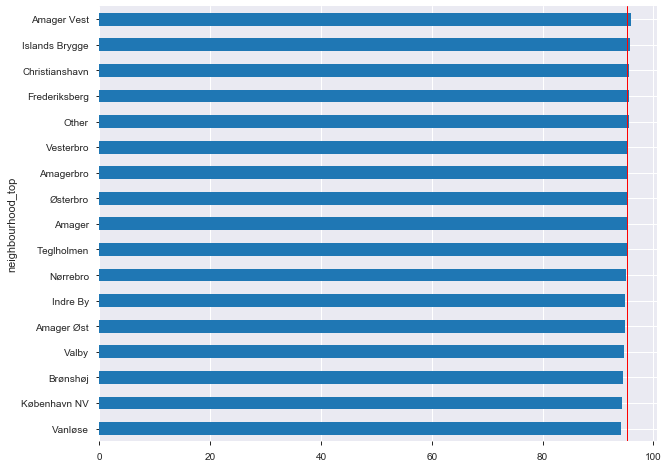

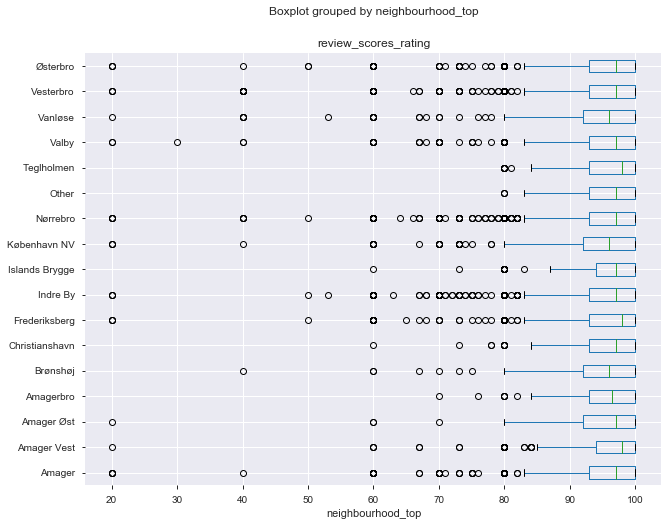

In [11]:
describe_numeric('neighbourhood_top', 'review_scores_rating', 
                 show_stdev=True, 
                 show_mean_ungrouped=True, show_mean_grouped=True, 
                 show_barchart=True, show_boxplot=True)

#### 1.B Best location

Standard deviation of means: 0.24111121005949154
Ungrouped mean: 9.590574247189075
neighbourhood_top
Christianshavn    9.949309
Indre By          9.893654
Islands Brygge    9.746725
Other             9.695238
Vesterbro         9.676215
Frederiksberg     9.662701
Nørrebro          9.598574
Amager Vest       9.577017
Amager            9.560303
Østerbro          9.540235
Amagerbro         9.534759
Amager Øst        9.512579
Teglholmen        9.342466
Valby             9.323347
Brønshøj          9.241895
Vanløse           9.228099
København NV      9.030822
Name: review_scores_location, dtype: float64


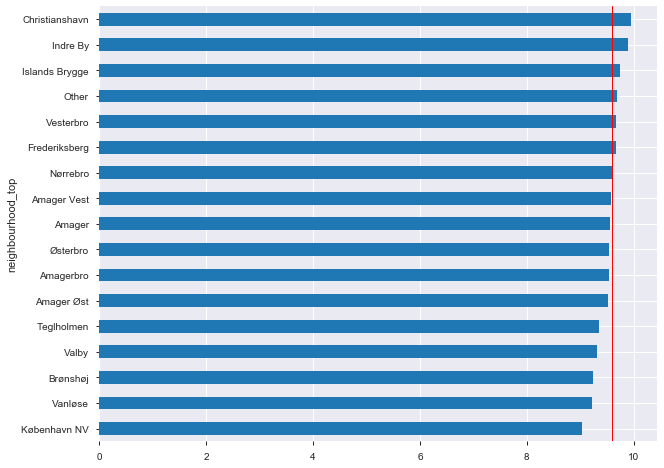

In [12]:
describe_numeric('neighbourhood_top', 'review_scores_location', 
                 show_stdev=True, 
                 show_mean_ungrouped=True, show_mean_grouped=True, 
                 show_barchart=True) 
#                  show_stdev=True, show_barchart=True)

#### 1.C Any other interesting trends by location?
Check if any other review categories have a high variance among the neighborhood averages.

In [13]:
describe_numeric('neighbourhood_top', 'review_scores_value', 
                 show_stdev=True)

Standard deviation of means: 0.05110210636922336


In [14]:
describe_numeric('neighbourhood_top', 'review_scores_communication', 
                 show_stdev=True)

Standard deviation of means: 0.03551443995858143


In [15]:
describe_numeric('neighbourhood_top', 'review_scores_checkin', 
                 show_stdev=True)

Standard deviation of means: 0.036429722862964066


In [16]:
describe_numeric('neighbourhood_top', 'review_scores_cleanliness', 
                 show_stdev=True)

Standard deviation of means: 0.07383083125566417


In [17]:
describe_numeric('neighbourhood_top', 'review_scores_accuracy', 
                 show_stdev=True)

Standard deviation of means: 0.03923012610480205


### 2. Display the average location rating on a map

In [18]:
# 6. visualize the data
# prepare a dataframe for mapping
count_listings = df.groupby('neighbourhood_top')['neighbourhood_top'].count()
mean_latitude = df.groupby('neighbourhood_top')['latitude'].mean()
mean_longitude = df.groupby('neighbourhood_top')['longitude'].mean()
mean_location_score = df.groupby('neighbourhood_top')['review_scores_location'].mean()
mean_location_score_ungrouped = df['review_scores_location'].mean()
diff_location_score = mean_location_score - mean_location_score_ungrouped
df_for_map = pd.DataFrame({
    'lat': mean_latitude,
    'lon': mean_longitude,
    'count_listings': count_listings,
    'mean_location_score': mean_location_score,
    'diff_location_score': diff_location_score
    })
df_for_map.reset_index(level=0, inplace=True)
df_for_map['text'] = df_for_map['neighbourhood_top'] + '; ' + \
'Average location score: ' + df_for_map['mean_location_score'].astype(str)
df_for_map.head()

,neighbourhood_top,lat,lon,count_listings,mean_location_score,diff_location_score,text
0,Amager,55.655861,12.601920,2340,9.560303,-0.030271,Amager; Average location score: 9.560302866414277
1,Amager Vest,55.651334,12.587681,1051,9.577017,-0.013557,Amager Vest; Average location score: 9.5770171...
2,Amager Øst,55.659250,12.616878,776,9.512579,-0.077996,Amager Øst; Average location score: 9.51257861...
3,Amagerbro,55.663465,12.612529,214,9.534759,-0.055815,Amagerbro; Average location score: 9.534759358...
4,Brønshøj,55.706578,12.490982,538,9.241895,-0.348679,Brønshøj; Average location score: 9.2418952618...


In [24]:
fig = px.scatter_geo(df_for_map, #locations="iso_alpha",
                     title="Average location score, difference from the Copenhagen average", 
                     lon = "lon", lat = "lat",
                     color="diff_location_score", # which column to use to set the color of markers
                     hover_name="text", # column added to hover information
                     size="count_listings", # size of markers
                     projection="natural earth")
fig.update_geos(#fitbounds="locations",
                resolution=50, 
                scope="europe",
#                 showsubunits=True, subunitcolor="Blue",
                lataxis_range=[55.5,55.8], lonaxis_range=[12.3, 13]
               )
fig.show()

### 3. Predicting the rating

In [95]:
# 3. clean and analyze the data
## Interesting columns
columns_of_interest = ['host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month', 'neighbourhood_top']

In [96]:
# missing ratings
print(df.shape)
print(np.mean(df.review_scores_rating.isnull()))

(28121, 107)
0.17286014010881548


In [97]:
# only take listings with ratings
# df_rated = df[df.review_scores_rating.notnull()]
df_rated = df.dropna(subset=['review_scores_rating'])
df_rated = df_rated[columns_of_interest]
print(df_rated.shape)

(23260, 51)


In [98]:
# missing
def missing_fraction(df, fieldnames):
    if isinstance(fieldnames, str):
        fieldnames = [fieldnames]
    for name in fieldnames:
        print('missing in {}: {:.1%}'.format(name, np.mean(df[name].isnull())))

missing_list = ['square_feet', 'cleaning_fee', 'security_deposit', 
                'host_response_time', 'host_response_rate', 'host_acceptance_rate']
missing_fraction(df_rated, missing_list)

missing in square_feet: 98.4%
missing in cleaning_fee: 27.0%
missing in security_deposit: 46.2%
missing in host_response_time: 55.0%
missing in host_response_rate: 55.0%
missing in host_acceptance_rate: 100.0%


#### A curious observation. 
By only allowing columns with no missing values (`allow_missing=0`) the count of remaining columns is just 23.
However, when setting `allow_missing` to `0.01` or `0.20` it doesn't change the count of remaining columns at 41.

This means that exactly half of the predictor columns with at least 80% of existing values actually have very few missing values. So it could be possible to avoid imputation while keeping most of the records.

In [99]:
# Drop the columns where there are more than the allowed fraction (allow_missing) of missing values
allow_missing = 0.01

col_set = set(df_rated.columns.values)
df_rated = df_rated.dropna(axis=1, thresh=df_rated.shape[0]*(1-allow_missing))

print(df_rated.shape)
print("dropped: ", col_set - set(df_rated.columns.values))

(23260, 41)
dropped:  {'square_feet', 'cleaning_fee', 'host_acceptance_rate', 'monthly_price', 'security_deposit', 'weekly_price', 'neighbourhood_group_cleansed', 'host_response_rate', 'host_response_time', 'host_neighbourhood'}


In [100]:
# drop rows with missing values
base = df_rated.shape[0]
df_rated = df_rated.dropna()
print(df_rated.shape)
print('{:.001%} dropped'.format(1-df_rated.shape[0]/base))

(23141, 41)
0.5% dropped


In [101]:
# drop rows with missing values
base = df_rated.shape[0]
df_rated = df_rated.dropna()
print(df_rated.shape)
print('{:.1%} dropped'.format(1-df_rated.shape[0]/base))

(23141, 41)
0.0% dropped


In [102]:
# Data cleansing
df_cleanse = df_rated

# Columns to cleanse
cols_dollar_price = ['price', 'extra_people']
cols_dates = ['host_since', 'first_review', 'last_review']

In [103]:
# Strings to timestamps
df_cleanse['host_since'] = pd.to_datetime(df_cleanse['host_since']).dt.date
df_cleanse['first_review'] = pd.to_datetime(df_cleanse['first_review']).dt.date
df_cleanse['last_review'] = pd.to_datetime(df_cleanse['last_review']).dt.date
print(max(df_cleanse['last_review']), ",", min(df_cleanse['first_review']), ",", max(df_cleanse['last_review']))
last_reference_day = max(max(df_cleanse['last_review']), max(df_cleanse['last_review']))

# Dates in day delta
df_cleanse['host_since_days'] = (last_reference_day - df_cleanse['host_since']).apply(lambda x: x.days)
df_cleanse['first_review_days'] = (last_reference_day - df_cleanse['first_review']).apply(lambda x: x.days)
df_cleanse['last_review_days'] = (last_reference_day - df_cleanse['last_review']).apply(lambda x: x.days)

2019-11-29 , 2009-09-04 , 2019-11-29


In [104]:
# Dollar price string to number
df_cleanse['price'] = df_cleanse['price'].apply(lambda x:float(x.replace('$', '').replace(',', '')))
df_cleanse['extra_people'] = df_cleanse['extra_people'].apply(lambda x:float(x.replace('$', '').replace(',', '')))
df_cleanse['price_plus1_log10'] = np.log10(df_cleanse['price'] + 1)
df_cleanse['extra_people_plus1_log10'] = np.log10(df_cleanse['extra_people'] + 1)

In [105]:
def create_dummy_df_noloop(df, cat_cols, dummy_na = False, drop_first = True):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    # subset the categorical columns and transform to dummy
    cat_df = df[cat_cols]
    dummy_cols_df = pd.get_dummies(cat_df, prefix=cat_cols, dummy_na=dummy_na, drop_first=drop_first)
    
    # join the numeric+dummy
    df_rest = df.drop(cat_cols, axis=1)
    
    resulting_df = pd.concat([df_rest, dummy_cols_df], axis=1)
    
    return resulting_df

In [106]:
# Booleans
cols_bool_to_dummy = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                      'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']

In [107]:
df_cleanse = create_dummy_df_noloop(df_cleanse, cols_bool_to_dummy)

In [108]:
# Join the average rating of a location

In [109]:
# average location score by neighborhood_top
df_for_map.head()

,neighbourhood_top,lat,lon,count_listings,mean_location_score,diff_location_score,text
0,Amager,55.655861,12.601920,2340,9.560303,-0.030271,Amager; Average location score: 9.560302866414277
1,Amager Vest,55.651334,12.587681,1051,9.577017,-0.013557,Amager Vest; Average location score: 9.5770171...
2,Amager Øst,55.659250,12.616878,776,9.512579,-0.077996,Amager Øst; Average location score: 9.51257861...
3,Amagerbro,55.663465,12.612529,214,9.534759,-0.055815,Amagerbro; Average location score: 9.534759358...
4,Brønshøj,55.706578,12.490982,538,9.241895,-0.348679,Brønshøj; Average location score: 9.2418952618...


In [110]:
#A.merge(B, left_on='lkey', right_on='rkey', how='outer')
mean_location_df = df_for_map[['neighbourhood_top', 'mean_location_score']]
df_cleanse = df_cleanse.merge(mean_location_df, on='neighbourhood_top', how='outer')

In [111]:
# Categorical to dummy
cols_cat_to_dummy = ['property_type_groups', 'room_type', 'bed_type', 'cancellation_policy'] #'neighbourhood_top'

In [112]:
df_cleanse.room_type.value_counts()

Entire home/apt    19473
Private room        3555
Shared room           68
Hotel room            45
Name: room_type, dtype: int64

In [113]:
df_cleanse.bed_type.value_counts()

Real Bed         22806
Pull-out Sofa      188
Futon               81
Couch               37
Airbed              29
Name: bed_type, dtype: int64

In [114]:
df_cleanse.cancellation_policy.value_counts()

flexible                       8936
moderate                       8024
strict_14_with_grace_period    6070
super_strict_60                  88
super_strict_30                  23
Name: cancellation_policy, dtype: int64

In [115]:
df_cleanse.property_type.value_counts()

Apartment                 19486
Condominium                1558
House                       995
Townhouse                   462
Loft                        221
Serviced apartment          130
Villa                       111
Hostel                       20
Guesthouse                   19
Houseboat                    17
Boat                         16
Guest suite                  16
Bed and breakfast            15
Bungalow                     14
Tiny house                   12
Other                        10
Cabin                         9
Hotel                         9
Cottage                       7
Boutique hotel                5
Camper/RV                     3
Hut                           2
Tent                          2
Casa particular (Cuba)        1
Island                        1
Name: property_type, dtype: int64

In [116]:
def property_type_new(series):
    if series in {'House', 'Townhouse', 'Bungalow', 'Tiny house', 'Cottage', 'Villa'}:
        return 'Houses'
    elif series in {'Apartment', 'Condominium', 'Loft', 'Serviced apartment'}:
        return 'Apartments'
    elif series in {'Hotel', 'Hostel', 'Guest suite', 'Bed and breakfast', 'Boutique hotel'}:
        return 'Hotels etc.'
    elif series in {'Cabin', 'Guesthouse', 'Camper/RV', 'Tent', 'Hut'}:
        return 'Camping/Glamping'
    elif series in {'Houseboat', 'Boat'}:
        return 'Boats'
    elif  series in {'Other', 'Casa particular (Cuba)', 'Island'}:
        return 'Other'
    else:
        return series
    
df_cleanse['property_type_groups'] = df_cleanse.property_type.apply(property_type_new)
df_cleanse['property_type_groups'].value_counts()

Apartments          21395
Houses               1601
Hotels etc.            65
Camping/Glamping       35
Boats                  33
Other                  12
Name: property_type_groups, dtype: int64

In [117]:
df_cleanse = create_dummy_df_noloop(df_cleanse, cols_cat_to_dummy)

In [68]:
# Data discovery with pandas_profiling
profile = ProfileReport(df_cleanse, title='Pandas Profiling Report', 
                        html={'style':{'full_width':True}}, 
                        minimal=True)
profile.to_widgets()

In [119]:
# 5. model the data
# Select columns for training
df_clenased = df_cleanse[['review_scores_rating',
                          'reviews_per_month', 'host_since_days', 'first_review_days', 'last_review_days',
#                           'price', 'extra_people',
                          'price_plus1_log10', 'extra_people_plus1_log10',
                          'mean_location_score',
                          'host_is_superhost_t', 'host_has_profile_pic_t', 'host_identity_verified_t', 
                          'instant_bookable_t', 
                          'require_guest_profile_picture_t', 'require_guest_phone_verification_t',
                          'property_type_groups_Boats',
                          'property_type_groups_Camping/Glamping', 'property_type_groups_Hotels etc.', 'property_type_groups_Houses', 'property_type_groups_Other', 
                          'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 
                          'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
                          'cancellation_policy_moderate', 'cancellation_policy_strict_14_with_grace_period', 'cancellation_policy_super_strict_30', 'cancellation_policy_super_strict_60']]

In [120]:
#Split into explanatory and response variables
X = df_clenased.drop('review_scores_rating', axis=1)
y = df_clenased['review_scores_rating']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [121]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [122]:
print(test_score)
print(train_score)

0.045698231538421785
0.05629751003231076


#### 1. What are the strongest positive or negative predictors for the rating of a listing?

In [123]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(50)

,est_int,coefs,abs_coefs
27,cancellation_policy_super_strict_30,-8.149805,8.149805
20,room_type_Shared room,-7.257265,7.257265
21,bed_type_Couch,5.297766,5.297766
17,property_type_groups_Other,4.711920,4.711920
28,cancellation_policy_super_strict_60,-4.638355,4.638355
22,bed_type_Futon,3.762868,3.762868
23,bed_type_Pull-out Sofa,3.606699,3.606699
24,bed_type_Real Bed,3.521954,3.521954
18,room_type_Hotel room,-3.238892,3.238892
7,host_is_superhost_t,2.095443,2.095443
